# Further Hypothesis Testing

In [1]:
# Select this cell and type Ctrl-Enter to execute the code below.

library(tidyverse)

set_plot_dimensions <- function(width_choice, height_choice) {
    options(repr.plot.width = width_choice, repr.plot.height = height_choice)
}

cbPal <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#CC79A7", "#0072B2", "#D55E00")

set_plot_dimensions(5, 4)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
# You should see "Attaching packages" and some ticks by the packages loaded.
# The "Conflicts" aren't a problem.

# Other problems loading the library? Try running this cell.

install.packages("tidyverse")

library(tidyverse)


## 8 - Goodness of fit

In [2]:
# Run this cell to load the data.

data <- read_csv("../assets/stars.csv")

type_key <- c("Brown Dwarf", "Red Dwarf", "White Dwarf", "Main Sequence", "Supergiant", "Hypergiant")
spectral_classes <- c("O", "B", "A", "F", "G", "K", "M")

data$type <- factor(data$type)
data$spectral_class <- factor(data$spectral_class, levels = spectral_classes)


Rows: 240 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): spectral_class
dbl (4): temperature, luminosity, radius, type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Your colleague Althea is not a fan of Prof. Xu's temperature scheme. She has her own ideas about how the star classification should be revised.

According to Althea's new theory of stellar evolution, there are two subtypes of hypergiant star, with very different temperature distributions. 

She says that our galaxy has approximately equal numbers of each subtype. 

If this theory is true, hypergiant temperatures should be distributed according to:

$$
P(3000K \leq \text{T} \lt 4000K) = 0.5 \\
P(4000K \leq \text{T} \lt 40000K) = 0.5
$$

with uniform temperature distributions within each of the two subtypes.

Althea asks you to check whether her theory agrees with your data set.

### Question: do hypergiants in the observed data set fit Althea's theory?

The pdf associated with the theory is piecewise uniform. We will start by constructing it as a bespoke function:

In [3]:
althea_pdf_single <- function(x) {
    if (x < 3000) {
        return(0)
    } else if (x < 4000) {
        return(0.5 / (4000 - 3000))
    } else if (x < 40000) {
        return(0.5 / (40000 - 4000))
    } else {
        return(0)
    }
}

# We can use the Vectorize() function to make a vector-friendly version of this pdf:
althea_pdf <- Vectorize(althea_pdf_single)


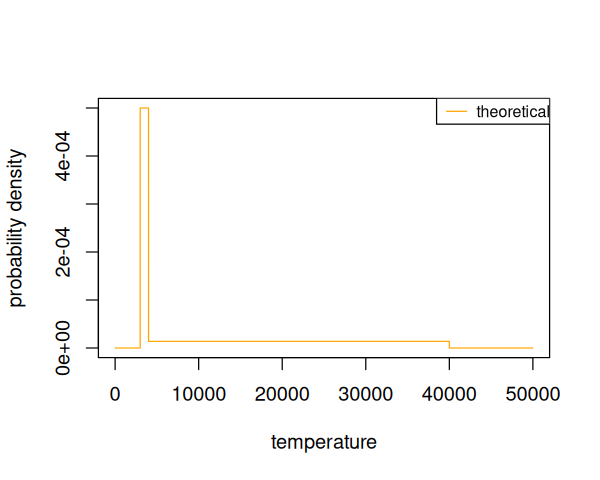

In [5]:

x <- seq(0, 50000)
y <- althea_pdf(x)

xlab <- "temperature"
ylab <- "probability density"

plot(x, y, type = "l", col = "orange", xlab = xlab, ylab = ylab, main = "")
legend("topright",
    legend = "theoretical pdf",
    col = "orange", lty = 1, cex = 0.8, y.intersp = 2
)


At first glance, the histogram for the hypergiants (type 5) does appear to have a similar shape to this pdf:

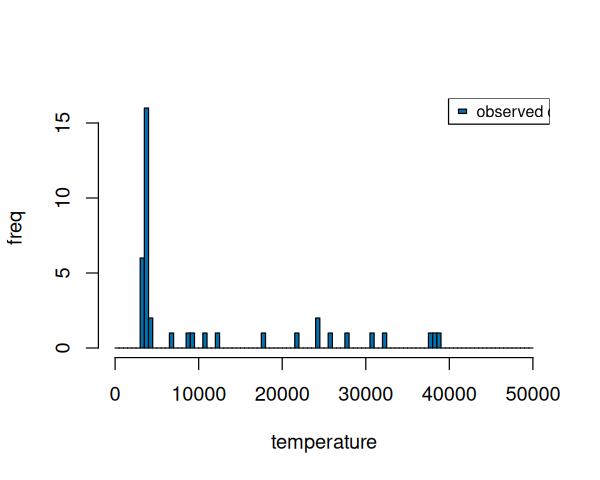

In [6]:
observed <- filter(data, type == 5)$temperature
n <- length(observed)

xlab <- "temperature"
ylab <- "freq"

bins <- seq(0, 50000, 500)

hist(observed, breaks = bins, xlab = xlab, ylab = ylab, col = cbPal[6], main = "")
legend("topright", legend = "observed data", fill = cbPal[6], cex = 0.8, y.intersp = 2)


To see more clealy, we can overlay a random sample of the same size ($n$=40), drawn from the theoretical distribution:

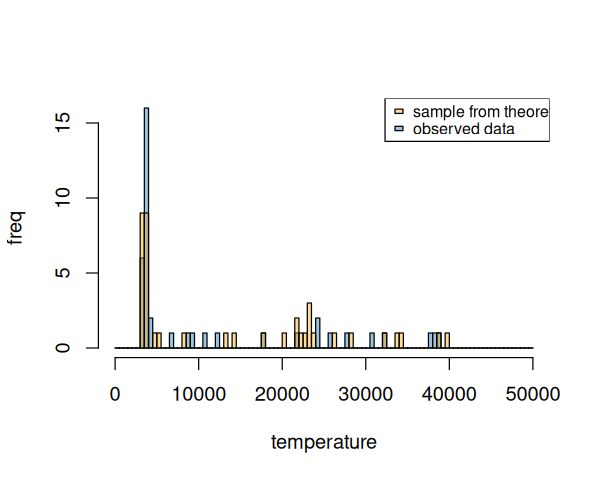

In [7]:
r <- runif(n = n, min = 0, max = 1)
sample <- rep(NA, n)
sample[r < 0.5] <- 3000 + (4000 - 3000) * (r[r < 0.5] / 0.5)
sample[r >= 0.5] <- 4000 + (40000 - 4000) * ((r[r >= 0.5] - 0.5) / 0.5)

xlab <- "temperature"
ylab <- "freq"

bins <- seq(0, 50000, 500)

# make new colours with transparency
or <- alpha("orange", 0.4)
bl <- alpha(cbPal[6], 0.4)

hist(observed, breaks = bins, xlab = xlab, ylab = ylab, col = bl, main = "")
hist(sample, breaks = bins, xlab = xlab, ylab = ylab, col = or, add = TRUE)
legend("topright",
    legend = c("sample from theoretical pdf", "observed data"),
    fill = c(or, bl), cex = 0.8, y.intersp = 2
)


How can we test more formally whether the observed data appear to be drawn from the theoretical distribution?

Here we have a theoretical distribution *which is not directly related to any of the standard statistical distributions*, so parametric methods such as the Shapiro-Wilk test are not applicable.

However, we can still perform a *non-parametric* goodness-of-fit test, by comparing the theoretical *cumulative* distributionfunction (cdf) with the empirical one. 

In [8]:
althea_cdf_single <- function(x) {
    if (x < 3000) {
        return(0)
    } else if (x < 4000) {
        return(0.5 * (x - 3000) / (4000 - 3000))
    } else if (x < 40000) {
        return(0.5 + 0.5 * (x - 4000) / (40000 - 4000))
    } else {
        return(1)
    }
}

# We can use the Vectorize() function to make a vector-friendly version of this cdf:
althea_cdf <- Vectorize(althea_cdf_single)


The empirical cdf is derived from the observed data using the `ecdf()` function.

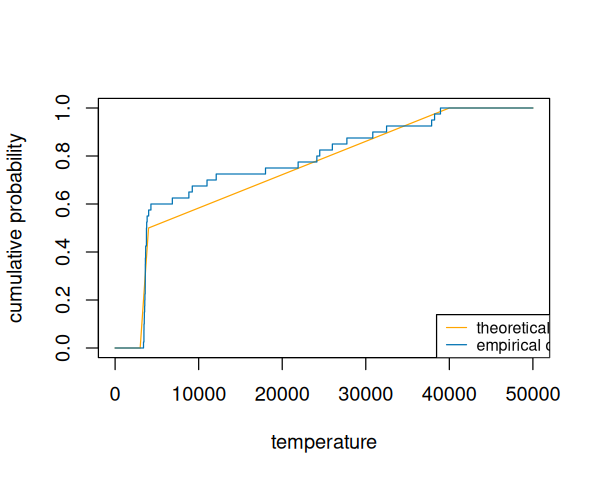

In [9]:

empirical_cdf <- ecdf(observed)

x <- seq(0, 50000)

xlab <- "temperature"
ylab <- "cumulative probability"

plot(x, althea_cdf(x), type = "l", col = "orange", xlab = xlab, ylab = ylab)
lines(x, empirical_cdf(x), type = "l", col = cbPal[6])
legend("bottomright",
    legend = c("theoretical cdf", "empirical cdf"),
    col = c("orange", cbPal[6]), lty = c(1, 1), cex = 0.8, y.intersp = 2
)


### Kolmogorov-Smirnov test

#### Theory

The [*Kolmogorov-Smirnov test*](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) (or K-S test) examines the deviation of the empirical cdf, $F_n(x)$, from the theoretical one, $F(x)$, to assess the goodness-of-fit. The test statistic is the quantity

$$
D_n= \sup_x |F_n(x)-F(x)|,
$$

i.e. the greatest vertical distance between the two lines in the plot above.

The distribution of $D_n$ under the null hypothesis $H_0: F_n(x) = F(x)$ is called the *Kolmogorov distribution*.

#### Application

In our example,

$H_0$: $F_n(x) = F(x)$  : The observed temperature distribution of hypergiants is described by Althea's theory.

$H_1$: $F_n(x) \ne F(x)$  : The observed temperature distribution of hypergiants is not described by Althea's theory.

$\alpha = 0.05$

Graphically, we can plot $D_n$ for each $x$-value in the plot above:

[1] "D_n: 0.1995"


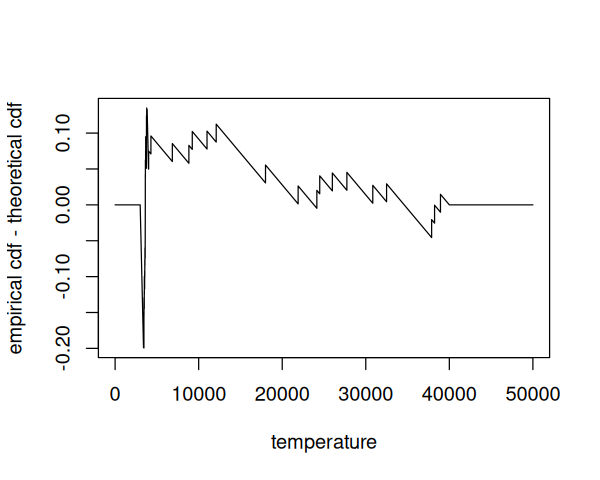

In [10]:
xlab <- "temperature"
ylab <- "empirical cdf - theoretical cdf"

x <- seq(0, 50000, 1)
y_values <- empirical_cdf(x) - althea_cdf(x)

plot(x, y_values, type = "l", xlab = xlab, ylab = ylab, col = "black")

D_n <- max(abs(y_values))
print(paste("D_n:", D_n))


The test itself is easy in R:

In [11]:
result <- ks.test(observed, althea_cdf)
print(result)


Warning message in ks.test.default(observed, althea_cdf):
“ties should not be present for the Kolmogorov-Smirnov test”



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  observed
D = 0.2, p-value = 0.08152
alternative hypothesis: two-sided



Owing to the rounding in the observed data, there are stars with identical temperatures, i.e. 'ties'. A warning appears because this can affect the calculation of the test statistic. Looking at the cdf plots, it appears unlikely that ties are responsible for much of the deviation between the two lines, so our results should still be reliable.

The resulting $p > \alpha$, so we accept the null hypothesis: the observed data appear to be compatible with Althea's theory.

### Other applications of the K-S test

#### Goodness of fit

The K-S test can be used as an alternative method for testing normality, or as a goodness-of-fit test for any other theoretical distribution. However, the standard test is only valid if the parameters (e.g. mean and variance) are *not* estimated from the data. 

If parameters *are* estimated from the data, we will need to use simulation to find an empirical distribution for $D_n$ under $H_0$.


#### Two sample test

`ks.test()` can also be used to compare two samples (in the absence of a theoretical cdf) to test whether they follow the same distribution. 

---
